In [194]:
import os
import numpy as np
import pandas as pd
import librosa as lb
from torchvision.transforms import v2
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [195]:
traindata_path = os.path.join(os.getcwd(), "train_audio") # Getting the paths for the labeled audio
csv_path = os.path.join(os.getcwd(), "train_metadata.csv") # Getting the path for the csv storing the metadata
columns_to_read = [
    "primary_label",
    "secondary_labels",
    "type",
    "latitude",
    "longitude",
    "common_name",
    "filename",
]

In [196]:
df = pd.read_csv(csv_path, usecols=columns_to_read)
print(df.shape)

(24459, 7)


In [197]:
df = df[:10]
print(df.shape)

(10, 7)


In [198]:
print(df.head())

  primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

              common_name             filename  
0  Asian Brown Flycatcher  asbfly/XC134896.ogg  
1  Asian Brown Flycatcher  asbfly/XC164848.ogg  
2  Asian Brown Flycatcher  asbfly/XC175797.ogg  
3  Asian Brown Flycatcher  asbfly/XC207738.ogg  
4  Asian Brown Flycatcher  asbfly/XC209218.ogg  


In [199]:
df = df[df.groupby("primary_label")["primary_label"].transform("count") >= 10]
one_hot_encoded_labels = pd.get_dummies(df["primary_label"], prefix="primary_label").astype(int)
df["one_hot_vector"] = one_hot_encoded_labels.values.tolist()
df["one_hot_vector"] = df["one_hot_vector"].apply(lambda x: np.array(x))
print(df.shape)
print(df.head())

(10, 8)
  primary_label secondary_labels      type  latitude  longitude  \
0        asbfly               []  ['call']   39.2297   118.1987   
1        asbfly               []  ['song']   51.4030   104.6401   
2        asbfly               []  ['song']   36.3319   127.3555   
3        asbfly               []  ['call']   21.1697    70.6005   
4        asbfly               []  ['call']   15.5442    73.7733   

              common_name             filename one_hot_vector  
0  Asian Brown Flycatcher  asbfly/XC134896.ogg            [1]  
1  Asian Brown Flycatcher  asbfly/XC164848.ogg            [1]  
2  Asian Brown Flycatcher  asbfly/XC175797.ogg            [1]  
3  Asian Brown Flycatcher  asbfly/XC207738.ogg            [1]  
4  Asian Brown Flycatcher  asbfly/XC209218.ogg            [1]  


In [200]:
train_df, temp_df = train_test_split(
    df,
    test_size=(1 - 0.8),
    random_state=42,
    stratify=df["primary_label"],
)

print(train_df.shape, temp_df.shape)

(8, 8) (2, 8)


In [201]:

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    stratify=temp_df["primary_label"],
)
print(val_df.shape, test_df.shape)

(1, 8) (1, 8)


In [202]:
train_labels = np.array(train_df["one_hot_vector"].values)
train_files = np.array(train_df["filename"].values)
train_latitude = train_df["latitude"].values.reshape(-1, 1)
train_longitude = train_df["longitude"].values.reshape(-1, 1)
train_common_name = np.array(train_df["common_name"].values)

val_labels = np.array(val_df["one_hot_vector"].values)
val_files = np.array(val_df["filename"].values)
val_latitude = val_df["latitude"].values.reshape(-1, 1)
val_longitude = val_df["longitude"].values.reshape(-1, 1)
val_common_name = np.array(val_df["common_name"].values)

test_labels = np.array(test_df["one_hot_vector"].values)
test_files = np.array(test_df["filename"].values)
test_latitude = test_df["latitude"].values.reshape(-1, 1)
test_longitude = test_df["longitude"].values.reshape(-1, 1)
test_common_name = np.array(test_df["common_name"].values)

print(train_labels[:5])

[array([1]) array([1]) array([1]) array([1]) array([1])]


In [203]:
scaler_latitude = StandardScaler()
scaler_longitude = StandardScaler()

train_latitude = scaler_latitude.fit_transform(train_latitude)
train_longitude = scaler_longitude.fit_transform(train_longitude)

val_latitude = scaler_latitude.transform(val_latitude)
val_longitude = scaler_longitude.transform(val_longitude)

test_latitude = scaler_latitude.transform(test_latitude)
test_longitude = scaler_longitude.transform(test_longitude)

train_position = np.hstack((train_latitude, train_longitude))
val_position = np.hstack((val_latitude, val_longitude))
test_position = np.hstack((test_latitude, test_longitude))

In [204]:
def process_audio(filenames, dataset_path):
    """This function makes the mel-scpectograms from the audio files"""
    mel_spectrograms = []
    for filename in filenames:
        audio_path = os.path.join(dataset_path, filename)
        if not os.path.exists(audio_path):
            print(f"Warning: File not found - {audio_path}")
            continue
        audio, sr = lb.load(audio_path, sr=32000)
        mel_spec = lb.feature.melspectrogram(y=audio, sr=sr, n_mels=128, fmax=sr / 2)
        mel_spec_db = lb.power_to_db(mel_spec, ref=np.max)
        mel_spectrograms.append(mel_spec_db)

    return mel_spectrograms

In [205]:
def show_sound(mel_spectogram, filename):
        """
        Displays the mel spectrogram of the audio file specified in the random_row.
        
        Parameters:
        random_row (pd.Series): A row from the DataFrame containing the mel spectrogram and filename.
        """

        audio, sr = lb.load(traindata_path + '/' + filename, sr=32000)
        duration = len(audio) / sr

        if mel_spectogram is not None: # Check if the spectrogram is not None
            plt.figure(figsize=(10, 4))
            lb.display.specshow(mel_spectogram, x_axis="time", y_axis="mel")
            plt.colorbar(format="%+2.0f dB")
            plt.title(f"Mel Spectrogram (dB) - {filename}")
            plt.xlabel("Time")
            plt.ylabel("Frequency")
            plt.tight_layout()   
            plt.xlim(0, duration)         
            plt.text(0.01, 0.02, f"Duration: {duration:.2f} seconds", ha='left', va='bottom',
                     transform=plt.gca().transAxes, fontsize=10,
                     bbox=dict(facecolor='white', alpha=0.5))
            plt.show()
        else:
            print("The selected spectrogram is None.")

In [206]:
train_spectograms = process_audio(train_files, traindata_path)

val_spectograms = process_audio(val_files, traindata_path)

test_spectograms = process_audio(test_files, traindata_path)


<class 'numpy.ndarray'>


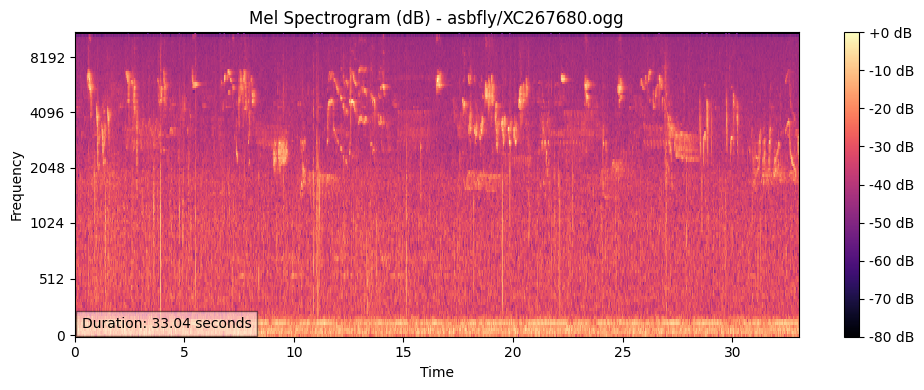

In [207]:
print(type(train_spectograms[0]))
show_sound(train_spectograms[0], train_files[0])

In [208]:
def standardize_individually(spectrograms):
    standardized_spectrograms = []
    for spec in spectrograms:
        mean = np.mean(spec)
        std = np.std(spec)
        
        if (std < 1e-6): # Avoid division by zero
            standardized_spectrograms.append(spec - mean)
        else:
            # Some serious standardization actions
            standardized_spectrograms.append((spec - mean) / std)
    return standardized_spectrograms

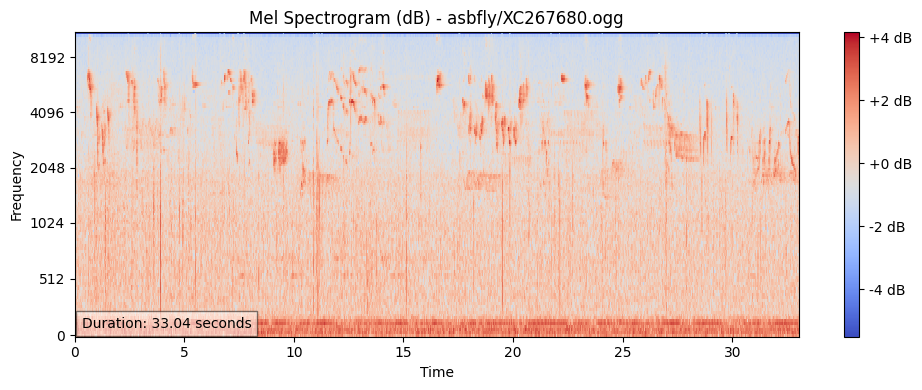

In [209]:
train_data = standardize_individually(train_spectograms)
val_data = standardize_individually(val_spectograms)
test_data = standardize_individually(test_spectograms)
show_sound(train_data[0], train_files[0])

In [210]:
train_transforms = []
val_transforms = []
test_transforms = []

# define transforms needed

In [211]:
train_transforms.append(v2.ToTensor())
val_transforms.append(v2.ToTensor())
test_transforms.append(v2.ToTensor())

/home/pongvins/miniconda3/envs/depphw/lib/python3.12/site-packages/torchvision/transforms/v2/_deprecated.py:42: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.Output is equivalent up to float precision.
  warnings.warn(


In [212]:
birdclef_data = dict()

birdclef_data["train"] = dict()

birdclef_data["train"]["data"] = train_data
birdclef_data["train"]["labels"] = train_labels
birdclef_data["train"]["position"] = train_position
birdclef_data["train"]["common_name"] = train_common_name
birdclef_data["train"]["files"] = train_files
birdclef_data["train"]["transforms"] = train_transforms

birdclef_data["val"] = dict()

birdclef_data["val"]["data"] = val_data
birdclef_data["val"]["labels"] = val_labels
birdclef_data["val"]["position"] = val_position
birdclef_data["val"]["common_name"] = val_common_name
birdclef_data["val"]["files"] = val_files
birdclef_data["val"]["transforms"] = val_transforms

birdclef_data["test"] = dict()

birdclef_data["test"]["data"] = test_data
birdclef_data["test"]["labels"] = test_labels
birdclef_data["test"]["position"] = test_position
birdclef_data["test"]["common_name"] = test_common_name
birdclef_data["test"]["files"] = test_files
birdclef_data["test"]["transforms"] = test_transforms

In [213]:
print(type(birdclef_data["train"]["data"][0]))
print(type(birdclef_data["train"]["labels"][0]))
print(type(birdclef_data["train"]["position"][0]))


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
